<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : 다양한 OCR모델 비교하기

# 1 사전 준비

## 1-1. 패키지 불러오기

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install --upgrade google-api-python-client
!pip install google-cloud-vision

In [5]:
import os
import matplotlib.pyplot as plt
import keras_ocr 
import pytesseract
from PIL import Image
from pytesseract import Output

## 1-2. 기본 code

In [6]:
# 인증키 경로 (클라우드 환경에서는 무시)
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  './data_eng/my_google_api_key.json'

# Google Cloud Vision API
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

# tesseract의 문자 검출 및 이미지 자르기 (detection)
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng', 
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

# tesseract의 잘린 이미지 단어 인식하기
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

def recognize_images2(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    image = Image.open(image_path)
    recognized_data = pytesseract.image_to_string(
        image, lang='eng',
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    print(recognized_data['text'])

# 2 검증용 데이터셋 준비

## 2-1. 소스 확보 방법

* 책사진 일부분 추출 및 아래 이미지 공유 사이트 다운로드
* 이미지 소스의 url: https://unsplash.com/s/photos/text
* 이미지 소스 제공자
> Brigitte Tohm <br>
> Eileen Pan <br>
> takwa abdo <br>
> Chris Curry <br>
> Fab Lentz <br>
> Viktor Forgacs<br>
> Alex Azabache <br>
> Anthony Garand <br>

In [ ]:
# 소스 download
!rm -r /content/data_eng
!mkdir -p /content/data_eng
!wget -O /content/compressed.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/ExplNode12/compressed.zip
!unzip /content/compressed.zip -d /content/data_eng
!rm /content/compressed.zip

## 2-2. 소스 구성 및 특징

In [32]:
# 검증용 데이터셋

image_locs = [
  './data_eng/01_BOOK.jpg',
  './data_eng/02_HANDWRITTEN.jpg',
  './data_eng/03_HANDWRITTEN2_brigitte-tohm-EAay7Aj4jbc-unsplash.jpg',
  './data_eng/04_SIGNBOARD_eileen-pan-5d5DSRQ5dUc-unsplash.jpg',
  './data_eng/05_CUP_takwa-abdo-W8_qA5I4LIo-unsplash.jpg',
  './data_eng/06_SHOW-WINDOW_chris-curry-UJij-wz7w88-unsplash.jpg',
  './data_eng/07_NEONSIGN_fab-lentz-mRMQwK513hY-unsplash.jpg',
  './data_eng/08_WALLPAPER_viktor-forgacs-qe5mRoPJjQ0-unsplash.jpg',
  './data_eng/09_BICYCLE_alex-azabache-V83v-MYB_Z8-unsplash.jpg',
  './data_eng/10_FRAME_anthony-garand-7RxMsJdvt7k-unsplash.jpg',
]
num_img = len(image_locs)
images = [ keras_ocr.tools.read(image) for image in image_locs]

# tesseract의 cropped images를 위한 전용 디렉토리
work_dirs = [
    './data_eng/tesseract/01',
    './data_eng/tesseract/02',
    './data_eng/tesseract/03',
    './data_eng/tesseract/04',
    './data_eng/tesseract/05',
    './data_eng/tesseract/06',
    './data_eng/tesseract/07',
    './data_eng/tesseract/08',
    './data_eng/tesseract/09',
    './data_eng/tesseract/10'
]
img_file_paths = [
  './data_eng/tesseract/01/01_BOOK.jpg',
  './data_eng/tesseract/02/02_HANDWRITTEN.jpg',
  './data_eng/tesseract/03/03_HANDWRITTEN2_brigitte-tohm-EAay7Aj4jbc-unsplash.jpg',
  './data_eng/tesseract/04/04_SIGNBOARD_eileen-pan-5d5DSRQ5dUc-unsplash.jpg',
  './data_eng/tesseract/05/05_CUP_takwa-abdo-W8_qA5I4LIo-unsplash.jpg',
  './data_eng/tesseract/06/06_SHOW-WINDOW_chris-curry-UJij-wz7w88-unsplash.jpg',
  './data_eng/tesseract/07/07_NEONSIGN_fab-lentz-mRMQwK513hY-unsplash.jpg',
  './data_eng/tesseract/08/08_WALLPAPER_viktor-forgacs-qe5mRoPJjQ0-unsplash.jpg',
  './data_eng/tesseract/09/09_BICYCLE_alex-azabache-V83v-MYB_Z8-unsplash.jpg',
  './data_eng/tesseract/10/10_FRAME_anthony-garand-7RxMsJdvt7k-unsplash.jpg',
]

# 3 성능 비교

## 3-1. Google Cloud Vision 모델 예측

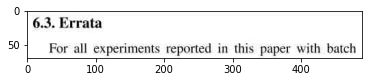

Texts:

"6.3. Errata
For all experiments reported in this paper with batch"

"6.3"

"."

"Errata"

"For"

"all"

"experiments"

"reported"

"in"

"this"

"paper"

"with"

"batch"
bounds: (437,47),(479,47),(479,64),(437,64)


In [9]:
# 01 사진 예측
i = 0
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

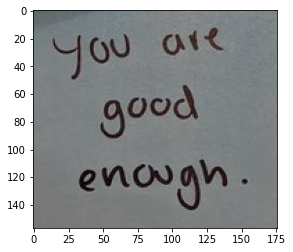

Texts:

"are
you
good
enough."

"are"

"you"

"good"

"enough"

"."
bounds: (143,108),(159,107),(160,137),(144,138)


In [10]:
# 02 사진 예측
i = 1
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

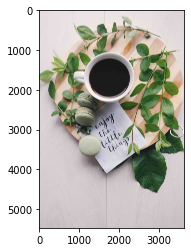

Texts:

"enjoy
the
little
things"

"enjoy"

"the"

"little"

"things"
bounds: (1703,3444),(2229,3123),(2341,3308),(1815,3628)


In [11]:
# 03 사진 예측
i = 2
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

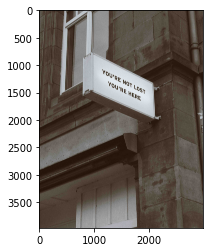

Texts:

"YOU'RE NOT LOST
YOU'RE HERE"

"YOU'RE"

"NOT"

"LOST"

"YOU'RE"

"HERE"
bounds: (1629,1472),(1873,1588),(1844,1649),(1600,1533)


In [12]:
# 04 사진 예측
i = 3
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

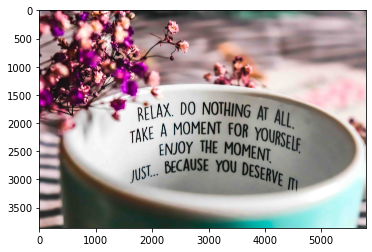

Texts:

"731
RELAX. DO NOTHING AT ALL.
TAKE A MOMENT FOR YOURSELF
ENJOY THE MOMENT.
JUST... BECAUSE YOU DESERVE ITI"

"731"

"RELAX"

"."

"DO"

"NOTHING"

"AT"

"ALL"

"."

"TAKE"

"A"

"MOMENT"

"FOR"

"YOURSELF"

"ENJOY"

"THE"

"MOMENT"

"."

"JUST"

"..."

"BECAUSE"

"YOU"

"DESERVE"

"ITI"
bounds: (4418,2960),(4643,3036),(4575,3239),(4349,3163)


In [13]:
# 05 사진 예측
i = 4
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

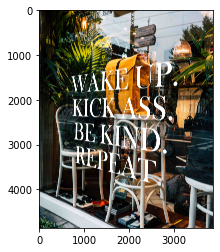

Texts:

"FINE
XXX
QNOOP
WAKE UP.
KICKASS
BE KIND.
REPEAT
ONL
M
ONOOP
QNOOP
UVIUNI"

"FINE"

"XXX"

"QNOOP"

"WAKE"

"UP"

"."

"KICKASS"

"BE"

"KIND"

"."

"REPEAT"

"ONL"

"M"

"ONOOP"

"QNOOP"

"UVIUNI"
bounds: (2841,4852),(2901,4807),(2910,4818),(2850,4864)


In [14]:
# 06 사진 예측
i = 5
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

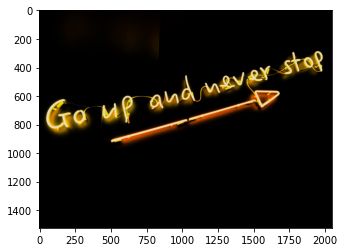

Texts:

"Go up and never stop"

"Go"

"up"

"and"

"never"

"stop"
bounds: (1663,287),(1978,217),(2030,450),(1715,520)


In [15]:
# 07 사진 예측
i = 6
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

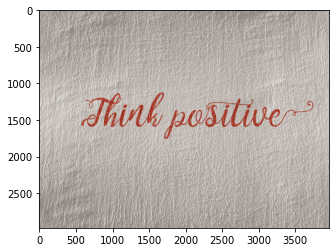

Texts:

"Think positive"

"Think"

"positive"
bounds: (1737,1154),(3357,1239),(3329,1765),(1709,1680)


In [16]:
# 08 사진 예측
i = 7
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

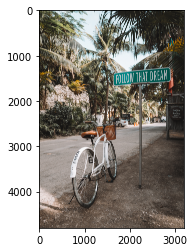

Texts:

"XMNU
FAVORIT
FAVORIT
BEACH
BEACH
PANTHER
MATE
FOLLOW THAT DREAM
KAYA
STEL- RAMION
ABLUE
LoLita
LoLita
Tulum
Quintana Roo"

"XMNU"

"FAVORIT"

"FAVORIT"

"BEACH"

"BEACH"

"PANTHER"

"MATE"

"FOLLOW"

"THAT"

"DREAM"

"KAYA"

"STEL-"

"RAMION"

"ABLUE"

"LoLita"

"LoLita"

"Tulum"

"Quintana"

"Roo"
bounds: (3081,2347),(3128,2349),(3127,2372),(3080,2370)


In [17]:
# 09 사진 예측
i = 8
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

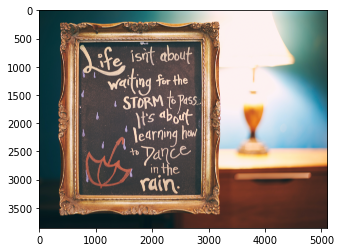

Texts:

"Life isn't about
waiting for the
STORM to pass..
It's about
learning how
6
W
to
Dance
in the
rain.
1"

"Life"

"isn't"

"about"

"waiting"

"for"

"the"

"STORM"

"to"

"pass"

".."

"It's"

"about"

"learning"

"how"

"6"

"W"

"to"

"Dance"

"in"

"the"

"rain"

"."

"1"
bounds: (967,1091),(1043,1131),(1005,1204),(928,1165)


In [18]:
# 10 사진 예측
i = 9
plt.imshow(images[i])
plt.show()
detect_text(image_locs[i])

## 3-2. Keras-ocr 모델 예측

In [20]:
# 모델 다운로드 및 예측
pipeline = keras_ocr.pipeline.Pipeline()
prediction_groups = [pipeline.recognize([url]) for url in image_locs]

# 예측결과에서 text만 추출
predictions = []
for i in range(0, len(prediction_groups)):
    predictions.append(prediction_groups[i][0])
predictions_word = []
for j in range(0, len(predictions)):
    predictions_word.append([word  for word, na in predictions[j]])

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


length: 11
prediction: ['63', 'errata', 'for', 'experiments', 'reported', 'this', 'with', 'batch', 'all', 'in', 'paper']


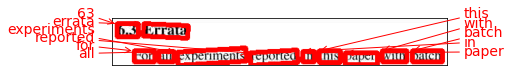

In [22]:
# 01 사진 예측
i = 0
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 4
prediction: ['atl', 'jou', 'good', 'enough']


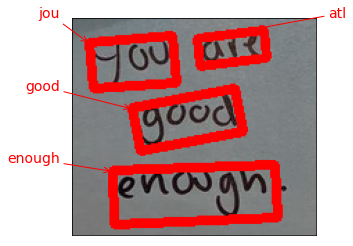

In [23]:
# 02 사진 예측
i = 1
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 3
prediction: ['teyy', 'little', 'things']


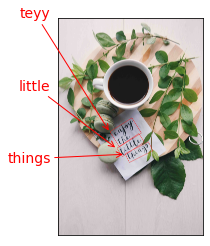

In [24]:
# 03 사진 예측
i = 2
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 5
prediction: ['youre', 'not', 'noure', 'lost', 'here']


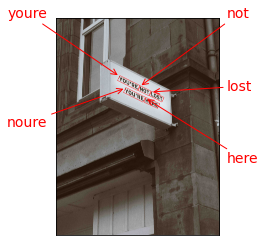

In [25]:
# 04 사진 예측
i = 3
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 18
prediction: ['do', 'nothing', 'relax', 'at', 'all', 'moment', 'for', 'a', 'take', 'yourself', 'the', 'enjoy', 'moment', 'because', 'you', 'deserve', 'just', 't']


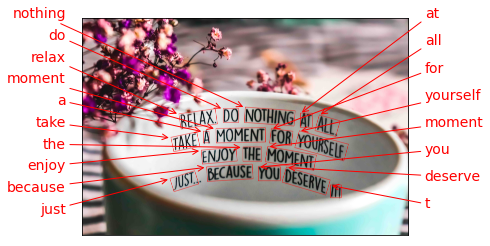

In [26]:
# 05 사진 예측
i = 4
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 10
prediction: ['dgat', 'fine', 'lt', 'wane', 'kickass', 'bekind', 'replat', 'onoop', 'moos', 'gnoop']


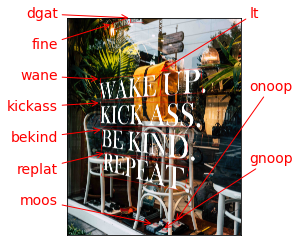

In [27]:
# 06 사진 예측
i = 5
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 4
prediction: ['oystol', 'ogaiv', 'up', 'cto']


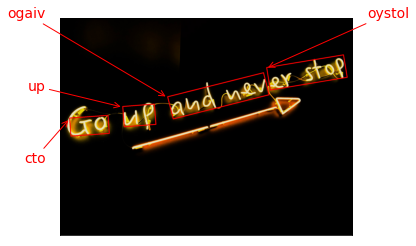

In [28]:
# 07 사진 예측
i = 6
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 2
prediction: ['jaina', 'hsllin']


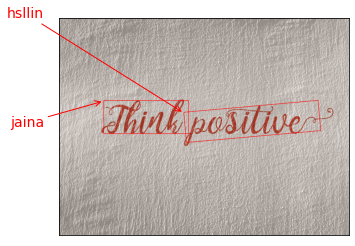

In [29]:
# 08 사진 예측
i = 7
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 13
prediction: ['dream', 'that', 'follow', 'lolita', 'lolita', 'kaya', 'tulum', 'quintana', 'roo', 'blue', 'favorit', 'dnw', 'beackes']


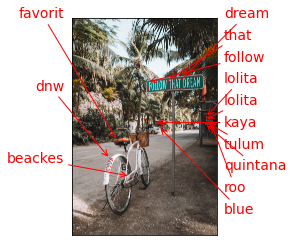

In [30]:
# 09 사진 예측
i = 8
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

length: 15
prediction: ['about', 'isint', 'ife', 'waiting', 'the', 'for', 'tlass', 'storm', 'dout', 'lts', 'how', 'slanig', 'the', 'in', 'rain']


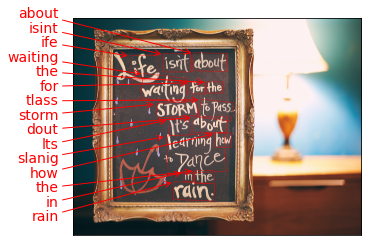

In [31]:
# 10 사진 예측
i = 9
keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions[i])
print('length:', len(predictions_word[i]))
print('prediction:', predictions_word[i])

## 3-3. Tesseract 모델 예측

In [34]:
# detection
cropped_image_path_lists = []
for i in range(0, len(work_dirs)):
    cropped_image_path_lists.append(crop_word_regions(img_file_paths[i], work_dirs[i]))

./data_eng/tesseract/01/0000.png
./data_eng/tesseract/01/0001.png
./data_eng/tesseract/01/0002.png
./data_eng/tesseract/01/0003.png
./data_eng/tesseract/01/0004.png
./data_eng/tesseract/01/0005.png
./data_eng/tesseract/01/0006.png
./data_eng/tesseract/01/0007.png
./data_eng/tesseract/01/0008.png
./data_eng/tesseract/01/0009.png
./data_eng/tesseract/01/0010.png
./data_eng/tesseract/02/0000.png
./data_eng/tesseract/02/0001.png
./data_eng/tesseract/02/0002.png
./data_eng/tesseract/02/0003.png
./data_eng/tesseract/02/0004.png
./data_eng/tesseract/02/0005.png
./data_eng/tesseract/02/0006.png
./data_eng/tesseract/02/0007.png
./data_eng/tesseract/03/0000.png
./data_eng/tesseract/04/0000.png
./data_eng/tesseract/05/0000.png
./data_eng/tesseract/06/0000.png
./data_eng/tesseract/07/0000.png
./data_eng/tesseract/08/0000.png


SystemError: ignored

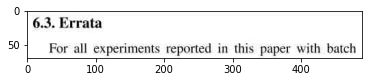

6.34.

K rrata

ror

all

experiments

reported

in

(his

Paper

with

hatch

Done


In [35]:
# 01 사진 예측
i = 0
plt.imshow(images[i])
plt.show()
recognize_images(cropped_image_path_lists[i])

# 4 모델 평가

## 4-1. Google Cloud Vision

## 4-2. Keras-ocr

## 4-3. Tesseract

# 5 회고